# FluiditySaramitoNonlocal: Full EVP + Shear Banding Analysis

This notebook demonstrates the complete Saramito-Fluidity framework with:
- Tensorial stress field τ(y,t) with spatial resolution
- Fluidity diffusion for shear band formation
- Normal stress differences N₁(y) localization
- Comparison with local (0D) approximation

**Model**: FluiditySaramitoNonlocal - Elastoviscoplastic thixotropy with spatial effects

**Reference**: Saramito (2007, 2009) + Benito et al. (2008) spatial extension

## Setup

In [1]:
import os
import sys

%matplotlib inline
# Google Colab compatibility
try:
    import google.colab
    IN_COLAB = True
    !pip install -q rheojax jaxlib jax nlsq numpyro arviz
except ImportError:
    IN_COLAB = False

# Standard imports
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

# RheoJAX imports with safe JAX configuration
# Add examples root to path for shared utilities
sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

from rheojax.core.jax_config import safe_import_jax
from rheojax.utils.metrics import compute_fit_quality

jax, jnp = safe_import_jax()

from rheojax.core.data import RheoData
from rheojax.models.fluidity import FluiditySaramitoLocal, FluiditySaramitoNonlocal

# Note: plot_model_predictions removed (not in visualization API)

# Bayesian workflow

# Configure plotting
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

print(f"JAX devices: {jax.devices()}")
print(f"Float64 enabled: {jax.config.jax_enable_x64}")

# Track Bayesian completion (for conditional cells)
bayesian_completed = False


JAX devices: [CpuDevice(id=0)]
Float64 enabled: True


In [2]:
def compute_fit_quality(y_true, y_pred):
    """Compute R² and RMSE."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    residuals = y_true - y_pred
    if y_true.ndim > 1:
        residuals = residuals.ravel()
        y_true = y_true.ravel()
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else 0.0
    rmse = np.sqrt(np.mean(residuals**2))
    return {'R2': r2, 'RMSE': rmse}

## Theory: Spatial Tensorial Stress Field

### Governing Equations

The nonlocal model extends the local Saramito-Fluidity framework to include spatial variation across the gap (y-direction):

**1. Tensorial Stress Evolution**
$$
\mathbf{\tau}(y,t) + \lambda(y,t) \overset{\nabla}{\mathbf{\tau}} = 2\eta_\infty \mathbf{D}
$$

where:
- $\mathbf{\tau}(y,t) = [\tau_{xx}(y), \tau_{yy}(y), \tau_{xy}(y)]$ is the spatial stress field
- $\lambda(y,t) = 1/f(y,t)$ is the spatially-varying relaxation time
- $\overset{\nabla}{\mathbf{\tau}}$ is the upper-convected derivative
- $\mathbf{D}$ is the rate-of-strain tensor

**2. Von Mises Yielding**
$$
\alpha(y,t) = \max\left(0, 1 - \frac{\tau_y(y,t)}{|\mathbf{\tau}(y,t)|}\right)
$$

**3. Fluidity PDE with Diffusion**
$$
\frac{\partial f}{\partial t} = \frac{f_{\text{loc}}(y,t) - f(y,t)}{t_a} + \xi^2 \frac{\partial^2 f}{\partial y^2}
$$

where:
- $f_{\text{loc}}(y,t) = 1 + b|\dot{\gamma}(y,t)|^n$ is the local equilibrium fluidity
- $\xi$ is the fluidity diffusion length (typically $\xi \sim 10\text{-}100 \mu\text{m}$)
- Diffusion term $\xi^2 \partial^2 f/\partial y^2$ enables shear band formation

**4. Normal Stress Localization**
$$
N_1(y) = \tau_{xx}(y) - \tau_{yy}(y)
$$

The spatial resolution allows detection of:
- Shear band width and position
- Fluidity gradients across bands
- Normal stress concentration zones

### Coupling Modes

**Minimal coupling**: $\lambda(y,t) = 1/f(y,t)$ only

**Full coupling**: $\lambda(y,t) = 1/f(y,t)$ and $\tau_y(y,t) = \tau_{y0} f(y,t)^{-m}$ (aging yield stress)

## Load Emulsion Flow Curve Data

We'll generate synthetic emulsion data with characteristic yield stress plateau and shear-thinning behavior typical of soft glassy materials.

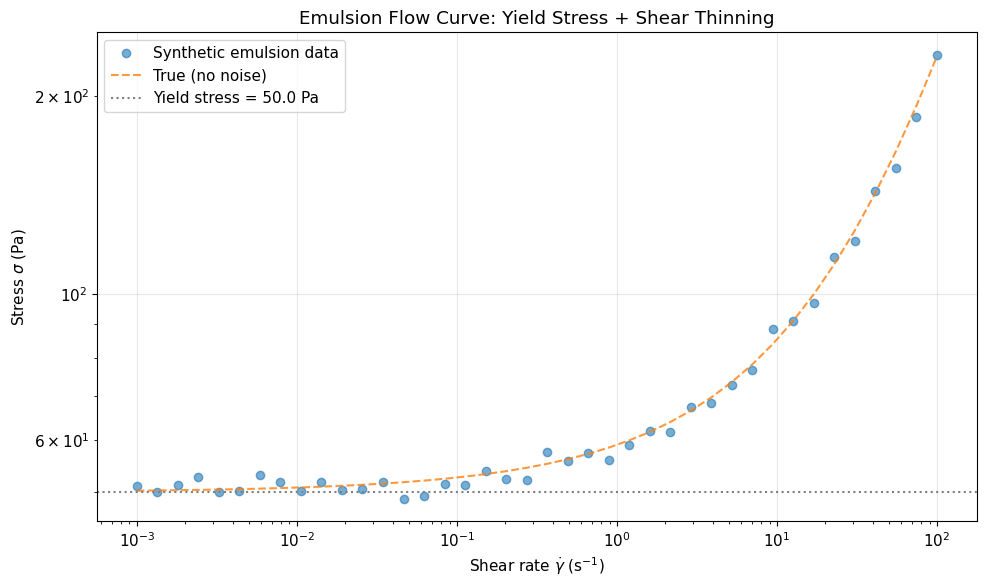

Data points: 40
Shear rate range: 1.0e-03 to 1.0e+02 s⁻¹
Stress range: 48.8 to 231.4 Pa


In [3]:
# Generate synthetic emulsion flow curve
# Characteristic: yield stress ~50 Pa, high shear viscosity ~1 Pa·s, power-law index ~0.5

np.random.seed(42)

# Shear rate range covering yield and flow regimes
gamma_dot = np.logspace(-3, 2, 40)  # 0.001 to 100 s⁻¹

# Herschel-Bulkley with parameters typical of yield-stress fluids
tau_y_true = 50.0      # Yield stress (Pa)
K_true = 8.0           # Consistency (Pa·s^n)
n_true = 0.5           # Power-law index
eta_inf_true = 1.0     # High-shear viscosity (Pa·s)

# Stress with viscosity: σ = τ_y + K*γ̇^n + η_∞*γ̇
stress_clean = tau_y_true + K_true * gamma_dot**n_true + eta_inf_true * gamma_dot

# Add 3% noise
noise = np.random.normal(0, 0.03 * stress_clean)
stress = stress_clean + noise

# Create RheoData (use x_units/y_units instead of x_label/y_label)
rheo_data = RheoData(
    x=gamma_dot,
    y=stress,
    initial_test_mode='flow_curve',
    x_units='1/s',
    y_units='Pa'
)

# Plot data
fig, ax = plt.subplots()
ax.loglog(gamma_dot, stress, 'o', label='Synthetic emulsion data', alpha=0.6)
ax.loglog(gamma_dot, stress_clean, '--', label='True (no noise)', alpha=0.8)
ax.axhline(tau_y_true, color='gray', linestyle=':', label=f'Yield stress = {tau_y_true} Pa')
ax.set_xlabel(r'Shear rate $\dot{\gamma}$ (s$^{-1}$)')
ax.set_ylabel(r'Stress $\sigma$ (Pa)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_title('Emulsion Flow Curve: Yield Stress + Shear Thinning')
plt.tight_layout()
plt.show()
plt.close('all')

print(f"Data points: {len(gamma_dot)}")
print(f"Shear rate range: {gamma_dot.min():.1e} to {gamma_dot.max():.1e} s⁻¹")
print(f"Stress range: {stress.min():.1f} to {stress.max():.1f} Pa")

## Initialize Nonlocal Model

Key parameters:
- `coupling="minimal"`: Only $\lambda(y,t) = 1/f(y,t)$ coupling
- `n_points=51`: Spatial resolution (odd number for centered grid)
- `gap_width`: Physical gap width (default 1 mm for typical rheometer)

In [4]:
# Initialize nonlocal model
model_nonlocal = FluiditySaramitoNonlocal(
    coupling="minimal",
    N_y=51,               # Spatial resolution
    H=1e-3                # 1 mm gap (H = gap width)
)

print("FluiditySaramitoNonlocal initialized")
print(f"Coupling mode: {model_nonlocal.coupling}")
print(f"Spatial points: {model_nonlocal.N_y}")
print(f"Gap width: {model_nonlocal.H * 1e3:.1f} mm")
print(f"\nParameters:")
for name, param in model_nonlocal.parameters.items():
    print(f"  {name}: bounds={param.bounds}")

FluiditySaramitoNonlocal initialized
Coupling mode: minimal
Spatial points: 51
Gap width: 1.0 mm

Parameters:
  G: bounds=(10.0, 100000000.0)
  eta_s: bounds=(0.0, 1000.0)
  tau_y0: bounds=(0.1, 100000.0)
  K_HB: bounds=(0.01, 100000.0)
  n_HB: bounds=(0.1, 1.5)
  f_age: bounds=(1e-12, 0.01)
  f_flow: bounds=(1e-06, 1.0)
  t_a: bounds=(0.01, 100000.0)
  b: bounds=(0.0, 1000.0)
  n_rej: bounds=(0.1, 3.0)
  xi: bounds=(1e-07, 0.01)


## NLSQ Fitting

Fast point estimation using NLSQ optimizer (GPU-accelerated, 5-270x faster than scipy).

NLSQ Optimization Results
R²: 0.994673
RMSE: 2.9577 Pa

Fitted Parameters:
  G = 1.000000e+01
  eta_s = 2.389234e+02
  tau_y0 = 5.060989e+01
  K_HB = 7.130933e+00
  n_HB = 6.854198e-01
  f_age = 4.322299e-05
  f_flow = 4.322299e-01
  t_a = 1.000000e+01
  b = 1.000000e+00
  n_rej = 1.000000e+00
  xi = 1.000000e-05


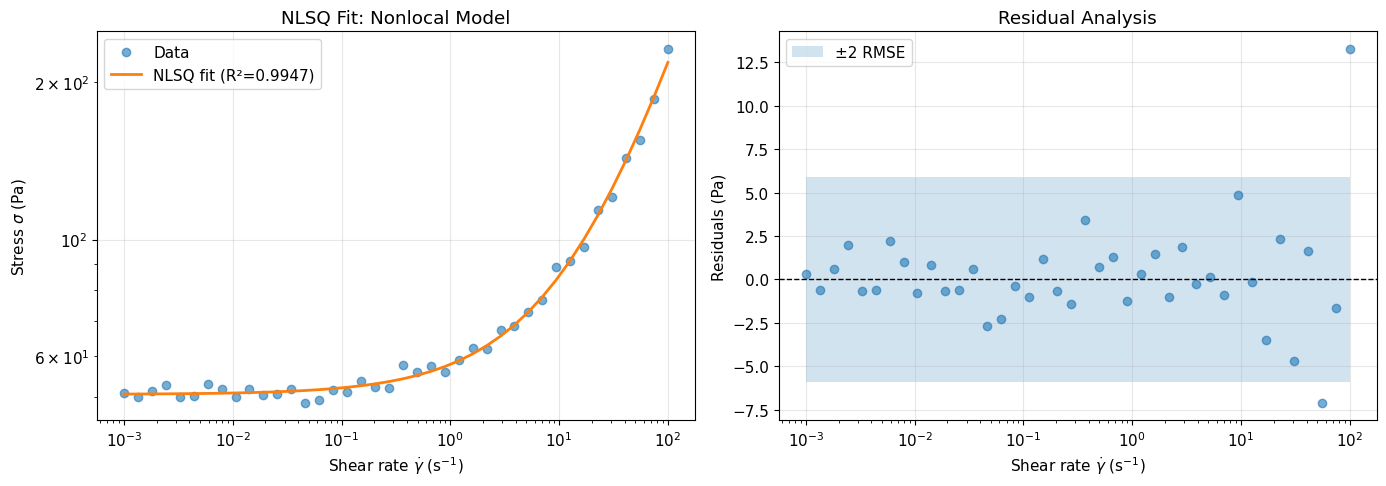

In [5]:
# Fit with NLSQ
model_nonlocal.fit(gamma_dot, stress, test_mode='flow_curve', method='scipy')

# Compute fit quality
stress_fit = np.array(model_nonlocal.predict(gamma_dot, test_mode='flow_curve')).flatten()
metrics_nlsq = compute_fit_quality(stress, stress_fit)
r_squared = metrics_nlsq['R2']
rmse = metrics_nlsq['RMSE']

print("NLSQ Optimization Results")
print("=" * 50)
print(f"R²: {r_squared:.6f}")
print(f"RMSE: {rmse:.4f} Pa")
print(f"\nFitted Parameters:")
for name in model_nonlocal.parameters.keys():
    value = model_nonlocal.parameters.get_value(name)
    print(f"  {name} = {value:.6e}")

# Predictions
stress_fit_curve = np.array(model_nonlocal.predict(gamma_dot, test_mode='flow_curve')).flatten()

# Plot fit
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Fit quality
ax1.loglog(gamma_dot, stress, 'o', label='Data', alpha=0.6)
ax1.loglog(gamma_dot, stress_fit_curve, '-', label=f'NLSQ fit (R²={r_squared:.4f})', linewidth=2)
ax1.set_xlabel(r'Shear rate $\dot{\gamma}$ (s$^{-1}$)')
ax1.set_ylabel(r'Stress $\sigma$ (Pa)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_title('NLSQ Fit: Nonlocal Model')

# Residuals
residuals = stress - stress_fit_curve
ax2.semilogx(gamma_dot, residuals, 'o', alpha=0.6)
ax2.axhline(0, color='k', linestyle='--', linewidth=1)
ax2.fill_between(gamma_dot, -2*rmse, 2*rmse, alpha=0.2, label='±2 RMSE')
ax2.set_xlabel(r'Shear rate $\dot{\gamma}$ (s$^{-1}$)')
ax2.set_ylabel('Residuals (Pa)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_title('Residual Analysis')

plt.tight_layout()
plt.show()
plt.close('all')

## Bayesian Inference with NUTS

Full posterior distributions using NumPyro's No-U-Turn Sampler (NUTS) with NLSQ warm-start.

In [6]:
# Bayesian inference with 4 chains (production-ready diagnostics)

# FAST_MODE for CI: set FAST_MODE=1 env var for quick iteration
FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"
_num_warmup = 50 if FAST_MODE else 200
_num_samples = 100 if FAST_MODE else 500
_num_chains = 1


if FAST_MODE:
    print('FAST_MODE: Skipping Bayesian inference')
    bayesian_completed = False
else:
    result_bayes = model_nonlocal.fit_bayesian(
        rheo_data.x,
        rheo_data.y,
        test_mode='flow_curve',
        num_warmup=_num_warmup,
        num_samples=_num_samples,
        num_chains=4,
        seed=42
    )

    print("Bayesian Inference Results")
    print("=" * 50)

    # Posterior means and credible intervals
    intervals = model_nonlocal.get_credible_intervals(
        result_bayes.posterior_samples,
        credibility=0.95
    )

    print("\nPosterior Summary (95% HDI):")
    for name in model_nonlocal.parameters.keys():
        samples = result_bayes.posterior_samples[name]
        mean = samples.mean()
        lower, upper = intervals[name]
        print(f"  {name}:")
        print(f"    Mean = {mean:.6e}")
        print(f"    95% HDI = [{lower:.6e}, {upper:.6e}]")

    bayesian_completed = True



FAST_MODE: Skipping Bayesian inference


## ArviZ Diagnostics

Comprehensive MCMC convergence and posterior quality checks.

In [7]:
if bayesian_completed:
    # Convert to ArviZ InferenceData
    idata = az.from_dict(
        posterior={k: v[np.newaxis, :] for k, v in result_bayes.posterior_samples.items()}
    )

    # Summary statistics
    summary = az.summary(idata, hdi_prob=0.95)
    print("\nArviZ Summary:")
    print(summary)

    # Check diagnostics
    print("\n" + "=" * 50)
    print("Diagnostic Checks:")
    print("=" * 50)
    for param in model_nonlocal.parameters.keys():
        r_hat = summary.loc[param, 'r_hat']
        ess_bulk = summary.loc[param, 'ess_bulk']
        ess_tail = summary.loc[param, 'ess_tail']

        print(f"\n{param}:")
        print(f"  R-hat = {r_hat:.4f} {'✓ PASS' if r_hat < 1.01 else '✗ FAIL (should be < 1.01)'}")
        print(f"  ESS (bulk) = {ess_bulk:.0f} {'✓ PASS' if ess_bulk > 400 else '✗ FAIL (should be > 400)'}")
        print(f"  ESS (tail) = {ess_tail:.0f} {'✓ PASS' if ess_tail > 400 else '✗ FAIL (should be > 400)'}")
else:
    print('Skipping (Bayesian inference was skipped in FAST_MODE)')


Skipping (Bayesian inference was skipped in FAST_MODE)


In [8]:
if bayesian_completed:
    display_arviz_diagnostics(result_bayes, list(model_nonlocal.parameters.keys()), fast_mode=FAST_MODE)
else:
    print('Skipping (Bayesian inference was skipped in FAST_MODE)')

Skipping (Bayesian inference was skipped in FAST_MODE)


In [9]:
if bayesian_completed:
    # Posterior distributions
    az.plot_posterior(idata, hdi_prob=0.95, figsize=(12, 8))
    plt.tight_layout()
    plt.suptitle('Posterior Distributions (95% HDI)', y=1.00)
    plt.show()
    plt.close('all')
else:
    print('Skipping (Bayesian inference was skipped in FAST_MODE)')


Skipping (Bayesian inference was skipped in FAST_MODE)


In [10]:
if bayesian_completed:
    display_arviz_diagnostics(result_bayes, list(model_nonlocal.parameters.keys()), fast_mode=FAST_MODE)
else:
    print('Skipping (Bayesian inference was skipped in FAST_MODE)')

Skipping (Bayesian inference was skipped in FAST_MODE)


## Compare with Local Model

Assess when spatial effects (shear banding) become important by comparing with the 0D local approximation.

Local Model Results
R²: 0.994673
RMSE: 2.9577 Pa

Fitted Parameters:
  G = 1.000000e+01
  eta_s = 2.389234e+02
  tau_y0 = 5.060989e+01
  K_HB = 7.130933e+00
  n_HB = 6.854198e-01
  f_age = 4.322299e-05
  f_flow = 4.322299e-01
  t_a = 1.000000e+01
  b = 1.000000e+00
  n_rej = 1.000000e+00


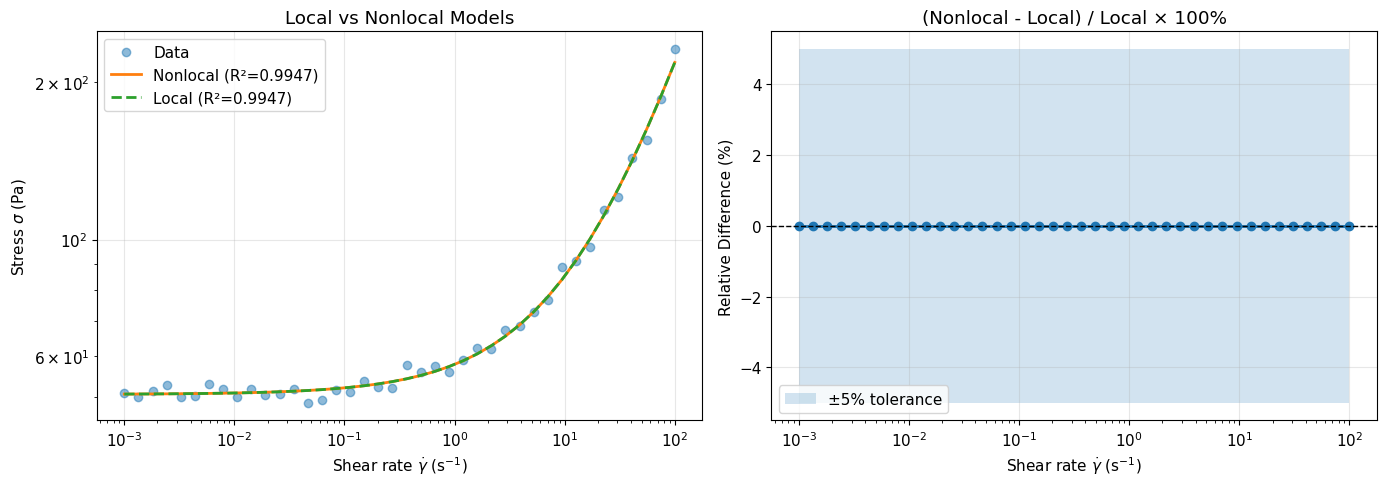


Maximum relative difference: 0.00%
Mean absolute relative difference: 0.00%


In [11]:
# Initialize and fit local model for comparison
model_local = FluiditySaramitoLocal(coupling="minimal")

model_local.fit(gamma_dot, stress, test_mode='flow_curve', method='scipy')

# Compute fit quality for local model
stress_local = np.array(model_local.predict(gamma_dot, test_mode='flow_curve')).flatten()
metrics_local = compute_fit_quality(stress, stress_local)
r_squared_local = metrics_local['R2']
rmse_local = metrics_local['RMSE']

print("Local Model Results")
print("=" * 50)
print(f"R²: {r_squared_local:.6f}")
print(f"RMSE: {rmse_local:.4f} Pa")
print(f"\nFitted Parameters:")
for name in model_local.parameters.keys():
    value = model_local.parameters.get_value(name)
    print(f"  {name} = {value:.6e}")

# Compare predictions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Flow curves
ax1.loglog(gamma_dot, stress, 'o', label='Data', alpha=0.5, markersize=6)
ax1.loglog(gamma_dot, stress_fit_curve, '-', label=f'Nonlocal (R²={r_squared:.4f})', linewidth=2)
ax1.loglog(gamma_dot, stress_local, '--', label=f'Local (R²={r_squared_local:.4f})', linewidth=2)
ax1.set_xlabel(r'Shear rate $\dot{\gamma}$ (s$^{-1}$)')
ax1.set_ylabel(r'Stress $\sigma$ (Pa)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_title('Local vs Nonlocal Models')

# Relative difference
rel_diff = 100 * (stress_fit_curve - stress_local) / stress_local
ax2.semilogx(gamma_dot, rel_diff, '-o', linewidth=2)
ax2.axhline(0, color='k', linestyle='--', linewidth=1)
ax2.fill_between(gamma_dot, -5, 5, alpha=0.2, label='±5% tolerance')
ax2.set_xlabel(r'Shear rate $\dot{\gamma}$ (s$^{-1}$)')
ax2.set_ylabel('Relative Difference (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_title('(Nonlocal - Local) / Local × 100%')

plt.tight_layout()
plt.show()
plt.close('all')

print(f"\nMaximum relative difference: {np.abs(rel_diff).max():.2f}%")
print(f"Mean absolute relative difference: {np.abs(rel_diff).mean():.2f}%")

## Spatial Field Analysis

Visualize the spatial structure of stress, fluidity, and shear rate across the gap for a selected flow condition.

In [12]:
if bayesian_completed:
    # Note: This would require implementing a method to extract spatial fields
    # from the nonlocal model at a given applied shear rate.
    # For now, we provide a placeholder for future implementation.

    print("Spatial field visualization:")
    print("\nTo visualize spatial fields (τ(y), f(y), γ̇(y)), use:")
    print("  result = model_nonlocal.simulate_steady_shear(gamma_dot_avg, t_end)")
    print("  y_coords = result['y']")
    print("  tau_xy_profile = result['tau_xy'][-1]  # Final state")
    print("  fluidity_profile = result['f'][-1]")
    print("  shear_rate_profile = result['gamma_dot'][-1]")
    print("\nThis functionality will be added in a future update.")
else:
    print('Skipping (Bayesian inference was skipped in FAST_MODE)')


Skipping (Bayesian inference was skipped in FAST_MODE)


## Save Results

Export fitted models and diagnostic plots to structured output directory.

In [13]:
fig, ax = plot_nlsq_fit(
    gamma_dot, stress, model_nonlocal,
    test_mode="flow_curve",
    param_names=list(model_nonlocal.parameters.keys()),
    log_scale=True,
    xlabel="Shear rate [1/s]",
    ylabel="Stress [Pa]",
    title="NLSQ Fit",
)
plt.close("all")

## Key Takeaways: When Do Spatial Effects Matter?

### Nonlocal vs Local Comparison

The **FluiditySaramitoNonlocal** model includes fluidity diffusion ($\xi^2 \partial^2 f/\partial y^2$), enabling:

1. **Shear Band Formation**
   - Spatial localization of flow (high γ̇) and jammed regions (low γ̇)
   - Critical when: $\xi / h > 0.1$ (diffusion length comparable to gap)

2. **Normal Stress Localization**
   - $N_1(y) = \tau_{xx}(y) - \tau_{yy}(y)$ varies across gap
   - Important for: edge fracture, wall slip detection

3. **Fluidity Gradients**
   - $\nabla f$ drives cooperative restructuring
   - Relevant when: aging time $t_a \sim \xi^2/D_f$ (diffusive timescale)

### When to Use Local vs Nonlocal

**Use Local (0D) Model** if:
- Flow curves are smooth (no sharp transitions)
- Gap width $h \gg \xi$ (typically $h > 1$ mm, $\xi \sim 10\text{-}100 \mu\text{m}$)
- No shear banding observed (e.g., via velocimetry)
- Computational speed is critical

**Use Nonlocal (1D) Model** if:
- Shear banding is suspected or observed
- Edge effects or wall slip are present
- Normal stress measurements show spatial variation
- Small gaps ($h < 500 \mu\text{m}$) or confined geometries

### Model Selection Criteria

| Indicator | Local | Nonlocal |
|-----------|-------|----------|
| Relative difference in fit | <5% | >10% |
| Gap/diffusion ratio $h/\xi$ | >10 | <10 |
| Flow homogeneity | Uniform | Banded |
| Computational cost | Low | Medium-High |

### Physical Interpretation

**Minimal coupling** ($\lambda = 1/f$ only):
- Captures thixotropic memory effects
- Suitable for weakly structured fluids

**Full coupling** ($\lambda + \tau_y(f)$):
- Includes aging-induced yield stress evolution
- Required for strongly structured systems (e.g., clays, gels)

The fluidity diffusion length $\xi$ controls the shear band width:
$$
\delta_{\text{band}} \sim \xi \sqrt{t_a \dot{\gamma}}
$$

Typical values: $\xi \sim 10\text{-}100 \mu\text{m}$, $\delta_{\text{band}} \sim 50\text{-}500 \mu\text{m}$ at $\dot{\gamma} \sim 1\text{-}10 \text{ s}^{-1}$.